### Seq 2 seq


In [1]:
# %load train_seq2seq.py
# %load reader.py
"""Functions for downloading and reading time series data."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from six.moves import xrange  # pylint: disable=redefined-builtin

from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import random_seed

import tensorflow as tf
from tensorflow.contrib import rnn
from reader import read_data_sets
from trnn import rnn_with_feed_prev,EinsumTensorRNNCell,tensor_rnn_with_feed_prev
import numpy 
from train_config import *


flags = tf.flags
flags.DEFINE_string("save_path", "./log/trnn/",
          "Model output directory.")
flags.DEFINE_integer("hidden_size", 16, "hidden layer size")
flags.DEFINE_float("learning_rate", 1e-2, "learning rate")
FLAGS = flags.FLAGS

'''
To forecast time series using a recurrent neural network, we consider every 
row as a sequence of short time series. Because dataset times series has 9 dim, we will then
handle 9 sequences for every sample.
'''

# Training Parameters
config = TrainConfig()
config.hidden_size = FLAGS.hidden_size
config.learning_rate = FLAGS.learning_rate
# Training Parameters
learning_rate = config.learning_rate
training_steps = 2000# config.training_steps
burn_in_steps = config.burn_in_steps
batch_size = config.batch_size
display_step = 200

inp_steps = burn_in_steps
dataset, stats = read_data_sets("./lorenz.npy", inp_steps, inp_steps)

# Network Parameters
num_input = stats['num_input']  # dataset data input (time series dimension: 3)
out_steps = 1+stats['num_steps']- burn_in_steps # adding EOS


# tf Graph input
X = tf.placeholder("float", [None, burn_in_steps, num_input])
Y = tf.placeholder("float", [None, out_steps, num_input])

# Decoder output
Z = tf.placeholder("float", [None, out_steps, num_input])

def Model(enc_inps, dec_inps, is_training):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, inp_steps, n_input)
    # Required shape: 'inp_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'inp_steps' tensors of shape (batch_size, n_input)
    # enc_inps = tf.unstack(enc_inps, inp_steps, 1)

#     def lstm_cell():
#         return tf.contrib.rnn.BasicLSTMCell(config.hidden_size,forget_bias=1.0)

#     cell = tf.contrib.rnn.MultiRNNCell(
#         [lstm_cell() for _ in range(config.num_layers)])
    def trnn_cell():
        return EinsumTensorRNNCell(config.hidden_size, config.num_lags, config.rank_vals)
        
    cell = tf.contrib.rnn.MultiRNNCell(
        [trnn_cell() for _ in range(config.num_layers)])

    with tf.variable_scope("Encoder", reuse=None):
        enc_outs, enc_states = tensor_rnn_with_feed_prev(cell, enc_inps, True, config)

    with tf.variable_scope("Decoder", reuse=None):
        config.burn_in_steps = 0
        dec_outs, dec_states = tensor_rnn_with_feed_prev(cell, dec_inps, is_training, config, enc_states)
    
    return dec_outs

with tf.name_scope("Train"):
    with tf.variable_scope("Model", reuse=None):
        train_pred = Model(X, Y, True)
with tf.name_scope("Test"):
    with tf.variable_scope("Model", reuse=True):
        test_pred = Model(X, Y, False)


# Define loss and optimizer
loss_op = tf.sqrt(tf.reduce_mean(tf.squared_difference(train_pred, Z)))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Write summary
tf.summary.scalar('loss', loss_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()


saver = tf.train.Saver()

# Start training
with tf.Session() as sess:
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(FLAGS.save_path + '/train',sess.graph)

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y, batch_z = dataset.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, Z:batch_z})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss 
            summary, loss = sess.run([merged,loss_op], feed_dict={X: batch_x,Y: batch_y, Z:batch_z})
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            train_writer.add_run_metadata(run_metadata, 'step%03d' % step)
            train_writer.add_summary(summary, step)
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) )

    print("Optimization Finished!")

    # Calculate accuracy for 128 dataset test inps
    test_len = 100
    test_enc_inps = dataset.test.enc_inps[:test_len].reshape((-1, inp_steps, num_input))
    test_dec_inps = dataset.test.dec_inps[:test_len].reshape((-1, out_steps, num_input))
    test_dec_outs = dataset.test.dec_outs[:test_len].reshape((-1, out_steps, num_input))

    
    # Fetch the predictions 
    fetches = {
        "true":Z,
        "pred":test_pred,
        "loss":loss_op
    }
    test_vals = sess.run(fetches, feed_dict={X: test_enc_inps, Y: test_dec_inps, Z: test_dec_outs})
    print("Testing Loss:", test_vals["loss"])

    # Save the variables to disk.
    save_path = saver.save(sess, FLAGS.save_path)
    print("Model saved in file: %s" % save_path)
    # Save predictions 
    numpy.save(save_path+"predict.npy", (test_vals["true"], test_vals["pred"]))
    # Save config file
    with open(save_path+"config.out", 'w') as f:
        f.write('hidden_size:'+ str(config.hidden_size)+'\t'+ 'learning_rate:'+ str(config.learning_rate)+ '\n')
        f.write('train_error:'+ str(loss) + '\n')

loading time series ...
input type  <class 'numpy.ndarray'> (1000, 100, 3)
normalize to (0-1)
Creating model @ training --> input = ground truth each timestep.
Creating model @ training --> input = ground truth each timestep.
Creating model @ training --> input = ground truth each timestep.
Creating model @ not training --> Feeding output back into input.
t 1 >= 0 --> feeding back output into input.
t 2 >= 0 --> feeding back output into input.
t 3 >= 0 --> feeding back output into input.
t 4 >= 0 --> feeding back output into input.
t 5 >= 0 --> feeding back output into input.
t 6 >= 0 --> feeding back output into input.
t 7 >= 0 --> feeding back output into input.
t 8 >= 0 --> feeding back output into input.
t 9 >= 0 --> feeding back output into input.
t 10 >= 0 --> feeding back output into input.
t 11 >= 0 --> feeding back output into input.
t 12 >= 0 --> feeding back output into input.
t 13 >= 0 --> feeding back output into input.
t 14 >= 0 --> feeding back output into input.
t 15 >=

In [2]:
import numpy 
numpy.save("./result/trnn_seq2seq_rank4.npy", (test_vals["true"], test_vals["pred"]))

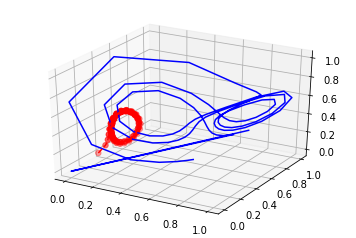

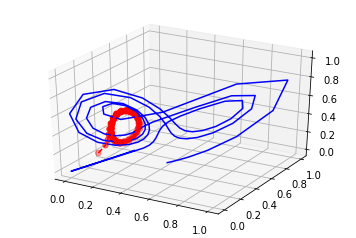

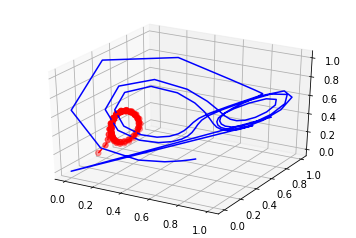

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_sample(pred, true, sample_id):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(true[sample_id, :,0], true[sample_id,:,1], true[sample_id, :,2], 'b')
    ax.scatter(pred[sample_id,:,0], pred[sample_id, :,1], pred[sample_id, :,2], c='r', s=30)
    ax.plot(pred[sample_id, :,0], pred[sample_id,:,1], pred[sample_id, :,2], 'r--')
pred = test_vals['pred']
true = test_vals['true']
plot_sample(pred, true,1)
plot_sample(pred, true,3)
plot_sample(pred, true,7)
# np.save('../experiments/result/trnn_10_err.npy',test_vals)

In [ ]:
import numpy as np
true, pred = np.load('./result/trnn_seq2seq.npy')
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_sample(pred, true, sample_id):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(true[sample_id, :,0], true[sample_id,:,1], true[sample_id, :,2], 'b')
    ax.scatter(pred[sample_id,:,0], pred[sample_id, :,1], pred[sample_id, :,2], c='r', s=30)
    ax.plot(pred[sample_id, :,0], pred[sample_id,:,1], pred[sample_id, :,2], 'r--')
for i in range(10):
    plot_sample(pred, true,i)
# plot_sample(pred, true,3)
# plot_sample(pred, true,20)